This notebook is the tester for developing a system for recording models in a simplistic method

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


model_vgg16 = tf.keras.applications.VGG16(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

model_vgg16_imagenet = tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)


model_vgg16_test = tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

model_resnet50 = tf.keras.applications.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=500,
    classifier_activation="softmax",
)


model_resnet50_imagenet = tf.keras.applications.ResNet50(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classifier_activation="softmax",
)

In [227]:
# From https://stackoverflow.com/questions/13530762/how-to-know-bytes-size-of-python-object-like-arrays-and-dictionaries-the-simp

import gc
import sys

def get_obj_size(obj):
    marked = {id(obj)}
    obj_q = [obj]
    sz = 0

    while obj_q:
        sz += sum(map(sys.getsizeof, obj_q))

        # Lookup all the object referred to by the object in obj_q.
        # See: https://docs.python.org/3.7/library/gc.html#gc.get_referents
        all_refr = ((id(o), o) for o in gc.get_referents(*obj_q))

        # Filter object that are already marked.
        # Using dict notation will prevent repeated objects.
        new_refr = {o_id: o for o_id, o in all_refr if o_id not in marked and not isinstance(o, type)}

        # The new obj_q will be the ones that were not marked,
        # and we will update marked with their ids so we will
        # not traverse them again.
        obj_q = new_refr.values()
        marked.update(new_refr.keys())

    return sz

import sys
   
print(get_obj_size(model_vgg16))

print(get_obj_size(model_resnet50))
print(get_obj_size(model_resnet50_imagenet))



157474351
157474327
157481324


In [2]:
import hashlib
from scipy.stats import skew

In [50]:


def create_layer_data(layer):

    # get structure array
    layer_structure  = {
        "class": layer.__class__.__name__,
        "input_shape": layer.input_shape,
        "output_shape": layer.output_shape,
        "trainable": layer.trainable,
        "params": layer.count_params(),
        "name": layer.name
    }

    # get layer weights and bias
    weights = layer.get_weights()
 

    if len(weights) == 0:
        calc_weight_std = 0
        calc_weight_mean = 0
        calc_bias_std = 0
        calc_bias_mean = 0
        calc_skew = 0

    if len(weights) == 1:
    #    weight_x = np.ndarray.flatten(weights[0])
        calc_weight_std = np.std(weights[0]).astype(float)
        calc_weight_mean = np.mean(weights[0]).astype(float)
        calc_skew = skew(np.ndarray.flatten(weights[0]))
        calc_bias_std = 0
        calc_bias_mean = 0

    if len(weights) > 1:
    #    weight_x = np.ndarray.flatten(weights[0])
    #    bias_x = np.ndarray.flatten(weights[1])
        calc_weight_std = np.std(weights[0]).astype(float)
        calc_weight_mean = np.mean(weights[0]).astype(float)
        calc_skew = skew(np.ndarray.flatten(weights[0]))
        calc_bias_std = np.std(weights[1]).astype(float)
        calc_bias_mean = np.mean(weights[1]).astype(float)
        #calc_skew = skew(weight_x)
        
    layer_values = {
        "weight_std" : calc_weight_std,
        "weight_mean" : calc_weight_mean,
        "bias_std" : calc_bias_std,
        "bias_mean" : calc_bias_mean,
        "skew" : calc_skew
    }

    return layer_structure, layer_values

def create_model_data(model):
    # initiate hashing function
    sha = hashlib.sha256()

    layer_data_set = {}
    layer_structure_set = {}
    
    for index, value in enumerate(model.layers):
        # Run through the layers
        layer_structure, layer_data = create_layer_data(value)
        # print(layer_data, layer_values, hash(layer_values))
        sha.update(repr(layer_structure).encode('utf-8'))
        sha.update(repr(layer_data).encode('utf-8'))

        layer_data_set[str(index)] = layer_data
        layer_structure_set[str(index)] = layer_structure

    
    layer_data = {"structure":layer_structure_set, "data":layer_data_set}
#    sha.update(repr(layer_data).encode('utf-8'))

    return sha.hexdigest(), layer_data




#     sha.update(repr(layer_data).encode('utf-8'))


In [53]:

signature1, layer_data1 = create_model_data(model_vgg16_imagenet)
print(signature1)
signature2, layer_data2 = create_model_data(model_vgg16_test)
print(signature2)

'''
0b4d6616162762f913eb7733446800441a7cb062be14be4ec33ea88e626672c8
c86581f6ec35f4d885fa9aa6fa8e98fbdd7f6eb800590543039c3badf92083c7
'''

0b4d6616162762f913eb7733446800441a7cb062be14be4ec33ea88e626672c8
c86581f6ec35f4d885fa9aa6fa8e98fbdd7f6eb800590543039c3badf92083c7


'\n0b4d6616162762f913eb7733446800441a7cb062be14be4ec33ea88e626672c8\nc86581f6ec35f4d885fa9aa6fa8e98fbdd7f6eb800590543039c3badf92083c7\n'

In [54]:
# setup global write variables
bb_username = 'brendan.bonner@mail.dcu.ie'
bb_organisation = 'DCU'
bb_model_source = 'created in python'

In [7]:
import pymongo
import datetime
from pymongo import MongoClient

from bson.objectid import ObjectId

def init_model_db():
    global db_col_data
    global db_col_signature


    dbclient = pymongo.MongoClient("mongodb://localhost:27017/")
    dbclient_database = dbclient["model_database"]
    db_col_data = dbclient_database["modeldata"]
    db_col_signature = dbclient_database["signature"]


    # Make sure signatures are unique on both
    db_col_signature.create_index(
        [("signature", pymongo.DESCENDING)],
        unique=True
    )


    remote_client = MongoClient('mongodb+srv://cluster0.7ilyj.mongodb.net/myFirstDatabase')
    dbclient_database_r = remote_client["model_database"]
    db_col_data_r = dbclient_database_r["modeldata"]
    db_col_signature_r = dbclient_database_r["signature"]
    
    
    remote_user = False
    if(remote_user):
        # Only if there is a remote account, allow writing, otherwise read only
        db_col_signature_r.create_index(
            [("signature", pymongo.DESCENDING)],
            unique=True
        )


def write_model_db(
    signature,
    model_data,
    username = bb_username,
    organisation = bb_organisation,
    model_source=bb_model_source,
    parent = '',
    local=True):

    if (local):
        db_data = db_col_data
        db_sig = db_col_signature
    else:
        db_data = db_col_data_r
        db_sig = db_col_signature_r

    # Insert Signature to Database (signatures)
    if get_model(signature) == None:
        x = db_col_data.insert_one(model_data)
        model_id = x.inserted_id
        # print(model_id, 'for sig: ', signature)

        # Inset Model Data to Database (modeldata)
        signature_data =  {
            'signature': signature,
            'parent': parent,
            'username': username,
            'organisation':organisation,
            'model_source': model_source,
            'model_data': model_id
        }

        x = db_col_signature.insert_one(signature_data)
        signature_model_id = x.inserted_id
        return signature_model_id
    else:
        print('signature: ', signature, ' already in database')
        return None


def push_model(model, local=True, parent=None, username=bb_username, organisation = bb_organisation):
    signature, layer_data = create_model_data(model)

    write_model_db(
        signature=signature,
        model_data=layer_data,
        parent=parent,
        username=username,
        organisation=organisation,
        local=local
    )
    return signature



def get_model(signature):
    signature_data = db_col_signature.find_one({'signature': signature})
    if(signature_data):
        return signature_data
    else:
        return None


# The web framework gets post_id from the URL and passes it as a string
def get_model_data(model_id):
    document = db_col_data.find_one({'_id': ObjectId(model_id)})
    return document


In [8]:
#initialise model database
init_model_db()

In [56]:
# get a signature and write it to the model


parent = push_model(model_resnet50)
last = push_model(model_resnet50_imagenet,parent=parent)
print(parent, last)
parent = push_model(model_vgg16_imagenet)
last = push_model(model_vgg16_test, parent=parent)
print(parent, last)


signature:  07e3d45e9bd45d3c19a4afb7c060f55ad06d7ff57cc561fb8091b6dec2ee3bce  already in database
signature:  c7e952212c1c260c0bba4d0624ef0baad6082470a18aa51798d33ea708874930  already in database
07e3d45e9bd45d3c19a4afb7c060f55ad06d7ff57cc561fb8091b6dec2ee3bce c7e952212c1c260c0bba4d0624ef0baad6082470a18aa51798d33ea708874930
signature:  0b4d6616162762f913eb7733446800441a7cb062be14be4ec33ea88e626672c8  already in database
signature:  c86581f6ec35f4d885fa9aa6fa8e98fbdd7f6eb800590543039c3badf92083c7  already in database
0b4d6616162762f913eb7733446800441a7cb062be14be4ec33ea88e626672c8 c86581f6ec35f4d885fa9aa6fa8e98fbdd7f6eb800590543039c3badf92083c7


In [57]:
# Make a small adjustment to test the SHA change
test_repeat = push_model(model_vgg16_test, parent=last, username='brendanboner@gmail.com')

for x in range(5):
    weights = model_vgg16_test.layers[1].get_weights()
    weights[0][0][0][0] = weights[0][0][0][0] * 1.004
    model_vgg16_test.layers[1].set_weights(weights)
    last = push_model(model_vgg16_test, parent=last)
    print(last)


signature:  c86581f6ec35f4d885fa9aa6fa8e98fbdd7f6eb800590543039c3badf92083c7  already in database
a6377f7bf73c88413c5cbd88e1658ef3e3611412924787b91f6fd2b73efb06c0
e67c542e25ec0913815bae7cdfbcc28f30eab525b9e82be448821b4cb39d2c8a
97f2e147308382f5195a8fac8bb9cce4ad3ced4e721197274deb11902b0d28a5
25c7f838721214cde1f5dc6f431bcbc03a12036b2c0d38c5e70fd549319a919f
392c5e4066e80f3f23390731c410843fe010c9baff3d9fc784dc7f4c4840f96c


In [60]:
# Get model and write to layer

def show_history(signature):

    print("Getting Signature: ",signature)
    signature_data = get_model(signature)
    if (signature_data):
        baseline_model_data = get_model_data(signature_data['model_data'])

        if baseline_model_data == None:
            print ('no model data for : ', signature_data['model_data'])
        else:
            print('Layers: ', len(baseline_model_data['data']))
            print( signature_data['_id'].generation_time, ' : Model Id ', signature_data['model_data'])
            old_data = baseline_model_data['data']

            history = []
            while signature_data['parent'] != None:

                # get model
                signature_data = get_model(signature_data['parent'])
                print( signature_data['_id'].generation_time, ' : Model Id ', signature_data['model_data'])

                new_model_data = get_model_data(signature_data['model_data'])
                if new_model_data == None:
                    print ('no model data for : ', signature_data['model_data'])
                else:
                    history_layer = []
                    data = new_model_data['data']
                    for key, value in data.items():
                        if (old_data[key]['weight_std'] == 0):
                            history_layer.append(old_data[key]['weight_std'])
                        else:
                            history_layer.append(
                                value['weight_std']  / old_data[key]['weight_std']
                            )

                    history.append(history_layer)
                    old_data = new_model_data['data']


    

            print(signature_data['username'], signature_data['organisation'])
            print(history[0])
    else:
        print('signature not found')




show_history('392c5e4066e80f3f23390731c410843fe010c9baff3d9fc784dc7f4c4840f96c')

show_history('c7e952212c1c260c0bba4d0624ef0baad6082470a18aa51798d33ea708874930') # ResNet50

Getting Signature:  392c5e4066e80f3f23390731c410843fe010c9baff3d9fc784dc7f4c4840f96c
Layers:  23
2021-08-03 02:53:34+00:00  : Model Id  6108afaea4950939dcc07cf4
2021-08-03 02:53:31+00:00  : Model Id  6108afaba4950939dcc07cf2
2021-08-03 02:53:28+00:00  : Model Id  6108afa8a4950939dcc07cf0
2021-08-03 02:53:25+00:00  : Model Id  6108afa5a4950939dcc07cee
2021-08-03 02:53:22+00:00  : Model Id  6108afa2a4950939dcc07cec
2021-08-03 02:53:03+00:00  : Model Id  6108af8fa4950939dcc07cea
2021-08-03 02:53:00+00:00  : Model Id  6108af8ca4950939dcc07ce8
brendan.bonner@mail.dcu.ie DCU
[0, 0.9998682486613316, 1.0, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 0, 1.0, 1.0, 1.0]
Getting Signature:  c7e952212c1c260c0bba4d0624ef0baad6082470a18aa51798d33ea708874930
Layers:  177
2021-08-03 02:52:55+00:00  : Model Id  6108af87a4950939dcc07ce6
2021-08-03 02:52:54+00:00  : Model Id  6108af86a4950939dcc07ce4
brendan.bonner@mail.dcu.ie DCU
[0, 0, 0.22031386583862042, 0.0, 0, 0, 0, 1.735222

In [6]:
def diff_model(model_vgg16, model_resnet50):
    for l1, l2 in zip(model_vgg16.layers, model_resnet50.layers):
        w1 = l1.get_weights()
        w2 = l2.get_weights()
        if len(w1) > 0:
            wa1 = np.ndarray.flatten(w1[0])
            wa2 = np.ndarray.flatten(w2[0])
            # Weights available
            print(l1.get_config()['name'],
                w1[0].shape,
                np.std(wa1), np.median(wa1),
                w2[0].shape,
                np.std(wa2), np.median(wa2),
                np.std(wa1) == np.std(wa2)
            )
            
        else:
            print(l1.get_config()['name'],len(w1))

In [ ]:
print(layer_data['structure'])

In [61]:
#Display a comparison of multiple layers
def get_weights_print_stats(layer):
    W = layer.get_weights()
    if len(W) > 0:
        print(len(W))
        print(W[0].shape)
    return W

def hist_weights(weights, bins=100, label='default'):
    for weight in weights:
        
        plt.hist(np.ndarray.flatten(weight), bins=bins, label=label)

'''
for l1, l2 in zip(model_vgg16.layers, model_resnet50.layers):
    print(l1.get_config()['name'])
    W = get_weights_print_stats(l1)
    hist_weights(W, label='Model 1')
    W = get_weights_print_stats(l2)
    hist_weights(W, label='Model 2')
    plt.show()
'''

show_all = False

hist_std1 = []
hist_std2 = []
hist_skew1 = []
hist_skew2 = []

for l1, l2 in zip(model_vgg16_imagenet.layers, model_vgg16.layers):

    w1 = l1.get_weights()
    w2 = l2.get_weights()


    if len(w1) > 0:
        # Layers available

        weight1_value   = np.ndarray.flatten(w1[0])
        weight1_skew  = skew(np.ndarray.flatten(w1[0]))
        weight1_std     = np.std(weight1_value).item()
        # print('std1 {:.4f}, skew1 {:.4f}'.format(weight1_std, weight1_skew))
        
        weight2_value   = np.ndarray.flatten(w2[0])
        weight2_skew  = skew(np.ndarray.flatten(w2[0]))
        weight2_std     = np.std(weight2_value).item()
        # print('std2 {:.4f}, skew2 {:.4f}'.format(weight2_std, weight2_skew))

        hist_std1.append(weight1_std)
        hist_std2.append(weight2_std)
        hist_skew1.append(weight1_skew)
        hist_skew2.append(weight2_skew)
        
        if show_all:
            print(l1.get_config()['name'],len(w1), w1[0].shape)
            plt.hist(
                [ np.ndarray.flatten(w1[0]),
                np.ndarray.flatten(w2[0])],
                alpha=0.5, bins=1000, label=['X','Y'])
            plt.legend(loc='upper right')

            plt.show()



std diff : -129930.5742 %
skw diff : 100.0000 %


<function matplotlib.pyplot.show(close=None, block=None)>

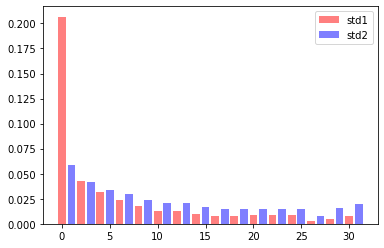

In [62]:
hist_std = 1
hist_skew = 1
for i,v in enumerate(hist_std1):
    if (v != 0):
        hist_std = (hist_std2[i] / v) * hist_std
    if (hist_skew1[i] != 0):
        hist_skew = (hist_skew2[i] / hist_skew1[i]) * hist_skew

print ('std diff : {:.4f} %'.format((1-hist_std) * 100))
print ('skw diff : {:.4f} %'.format((1-hist_skew) * 100))

layers = len(hist_std1)
plt.bar( np.arange(layers) * 2, hist_std1, color = 'red' , alpha=0.5, label='std1')
plt.bar( np.arange(layers)* 2 + 1, hist_std2, color = 'blue', alpha=0.5, label='std2' )
plt.legend(loc='upper right')

plt.show



16


<function matplotlib.pyplot.show(close=None, block=None)>

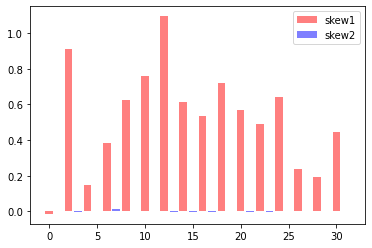

In [63]:
layers = len(hist_skew1)
print(layers)
plt.bar( np.arange(layers) * 2, hist_skew1, color = 'red' , alpha=0.5, label='skew1')
plt.bar( np.arange(layers)* 2 + 1, hist_skew2, color = 'blue', alpha=0.5, label='skew2' )
plt.legend(loc='upper right')
plt.show